In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [3]:
# Crea i dati per predire il prezzo tra 3 ggs

stock = "ORCL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

df["Train"] = df["Close"].shift(-3)
df.dropna(subset=['Train'], inplace=True)


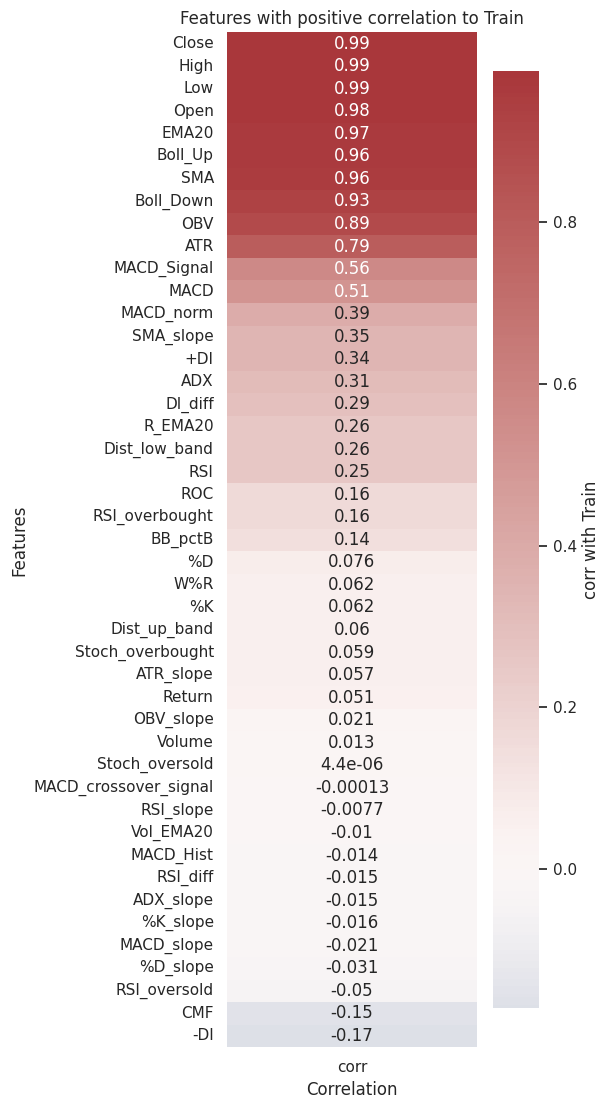

In [4]:
# List features with correlation > 0 w.r.t 'Train' and plot their correlations
if 'Train' not in df.columns:
    print("Column 'Train' not found in df. Run the data prep cell first.")
else:
    # Espressa anche close, per retrocmpatibiltà con il codice sotto stante
    corr = df.corr()
    # extract correlation with Train (drop the Train->Train self-correlation)
    corr_train = corr['Train'].drop(labels=['Train'], errors='ignore')
    significant_features = corr_train.sort_values(ascending=False)

    
    plt.figure(figsize=(6, max(4, 0.25 * len(significant_features))))
    sns.set_theme(style='white')
    # Convert to DataFrame for heatmap (required shape: (n, 1))
    pos_df = significant_features.to_frame('corr')
    ax = sns.heatmap(pos_df, annot=True, cmap='vlag', center=0, cbar_kws={'label': 'corr with Train'})
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Features')
    plt.title("Features with positive correlation to Train")
    plt.tight_layout()
    plt.show()

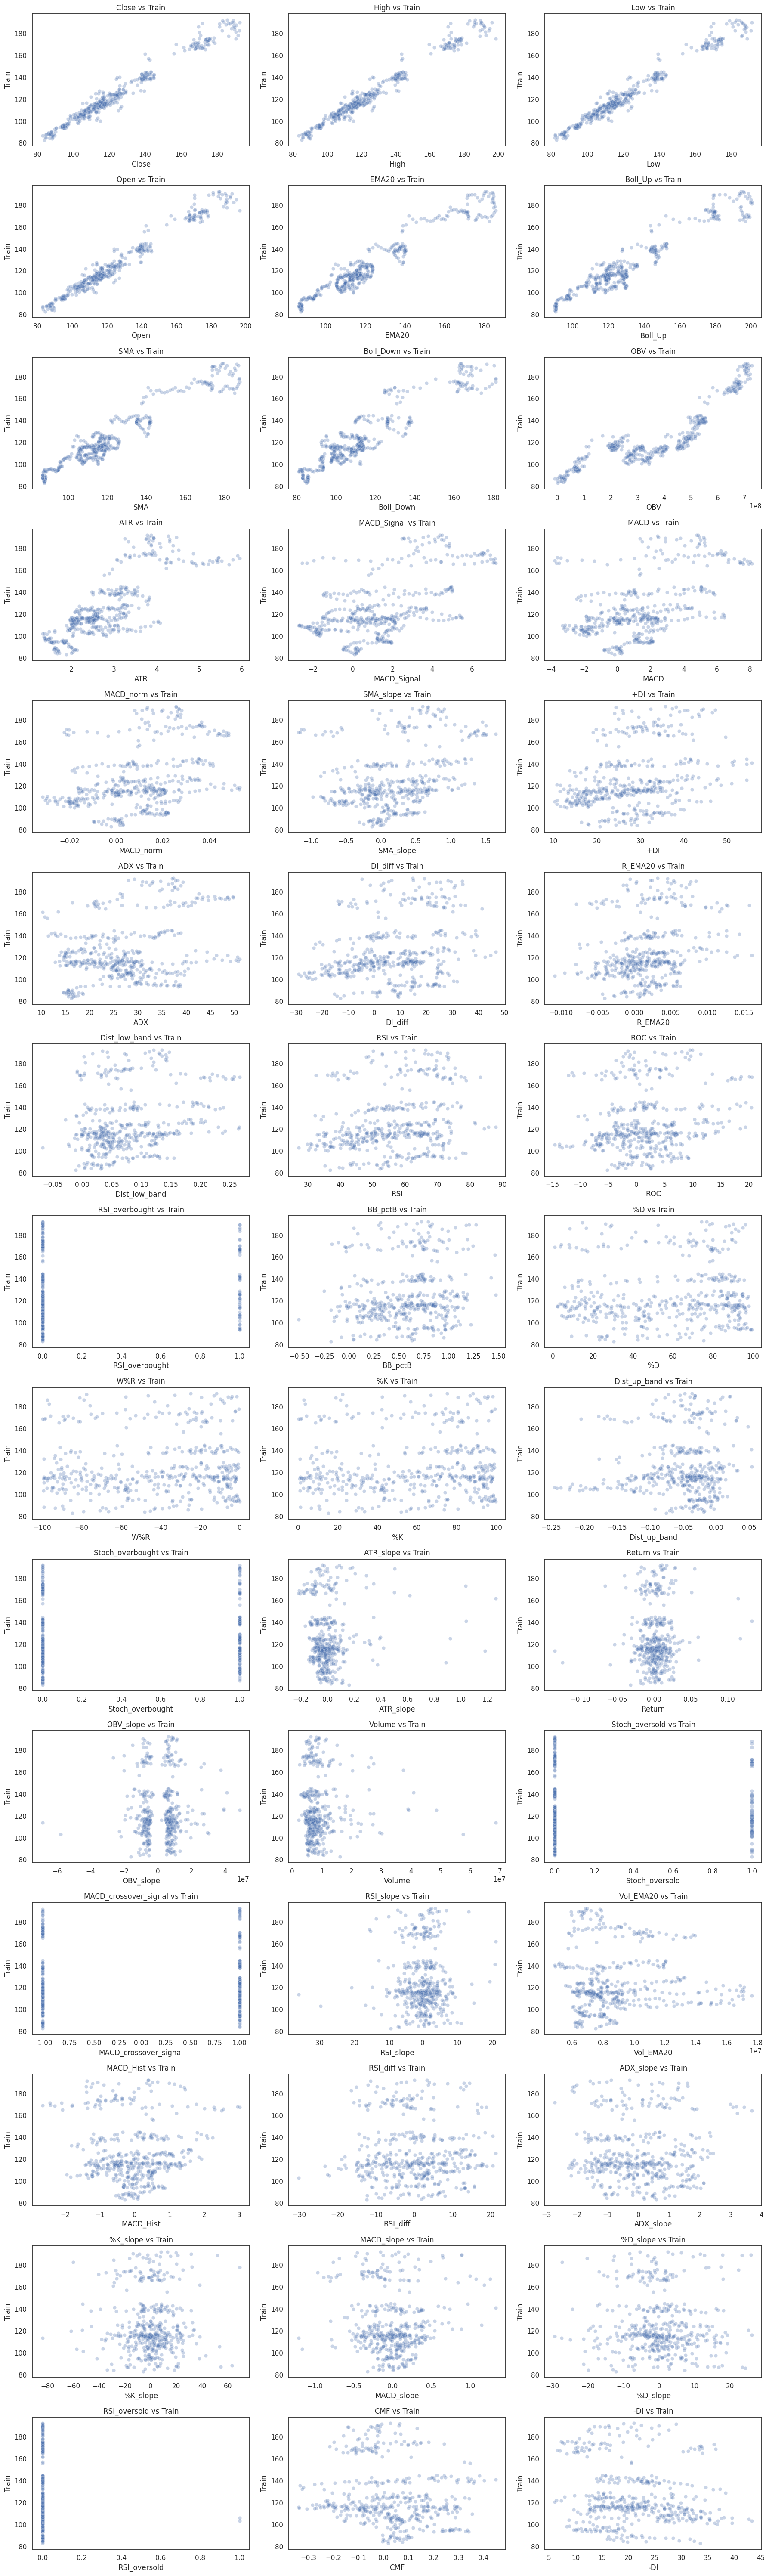

In [5]:
#Scatter plot
cols = list(df[significant_features.index].columns)
n = len(cols)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 4), squeeze=False)
axes_flat = axes.flatten()
for idx, col in enumerate(cols):
    ax = axes_flat[idx]
    sns.scatterplot(ax=ax, data=df, x=col, y='Train', alpha=0.3)
    ax.set_title(f"{col} vs Train")
# hide any unused subplots
for ax in axes_flat[n:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

In [18]:
#Data set 
# help error: MAE, 

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

data_set = []
tscv = TimeSeriesSplit(n_splits=6)
split = pd.Timestamp("2024-8-01")

for stock in stocks:

    dataf = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    ) 

    
    dataf["Train"] = dataf["Close"].shift(-3)
    dataf.dropna(subset=['Train'], inplace=True)

    X = dataf.drop(columns=["Train"])
    Y = dataf["Train"].copy()
    
    data_set.append({
        "X_train": X[X.index <= split].copy(),
        "X_test": X[X.index > split].copy(),
        "Y_train": Y[Y.index <= split].copy(),
        "Y_test": Y[Y.index > split].copy(),
        "Reality": dataf.loc[X[X.index > split].index, "Close"].copy()
    })


#for train_idx, test_idx in tscv.split(X):
#    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
#    
#    # Only keep the Close values that correspond to the test indices
#    data_set.append({
#        "X_train": X_train.copy(),
#        "X_test": X_test.copy(),
#        "Y_train": Y_train.copy(),
#        "Y_test": Y_test.copy(),
#        "Reality": df.loc[X_test.index, "Close"].copy()
#    })




/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._res

Stock: ORCL
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 7.6849 | MAE: 5.9790 | R2: 0.8141 | base R2: 0.8875
                           coef  mean_abs_shap
High                    7.92936        427.923
Close                    4.2755        227.993
-DI                     1.60283        12.0983
+DI                     1.10811        7.54649
MACD_crossover_signal  0.938209       0.933794
Stoch_overbought       0.701118       0.308492
Boll_Down              0.695437        31.9748
ADX_slope             -0.312314       0.341121
RSI_overbought        -0.264733      0.0647817
%D_slope              -0.204761        1.34786
Vol_EMA20              -0.12957         279884
MACD_slope            0.0652249      0.0231923
Return                0.0426829    0.000600625
%D                    0.0380631        0.95057
CMF                   0.0236967     0.00287903
RSI                          -0              0
MACD_Hist                    -0              0
MACD                   

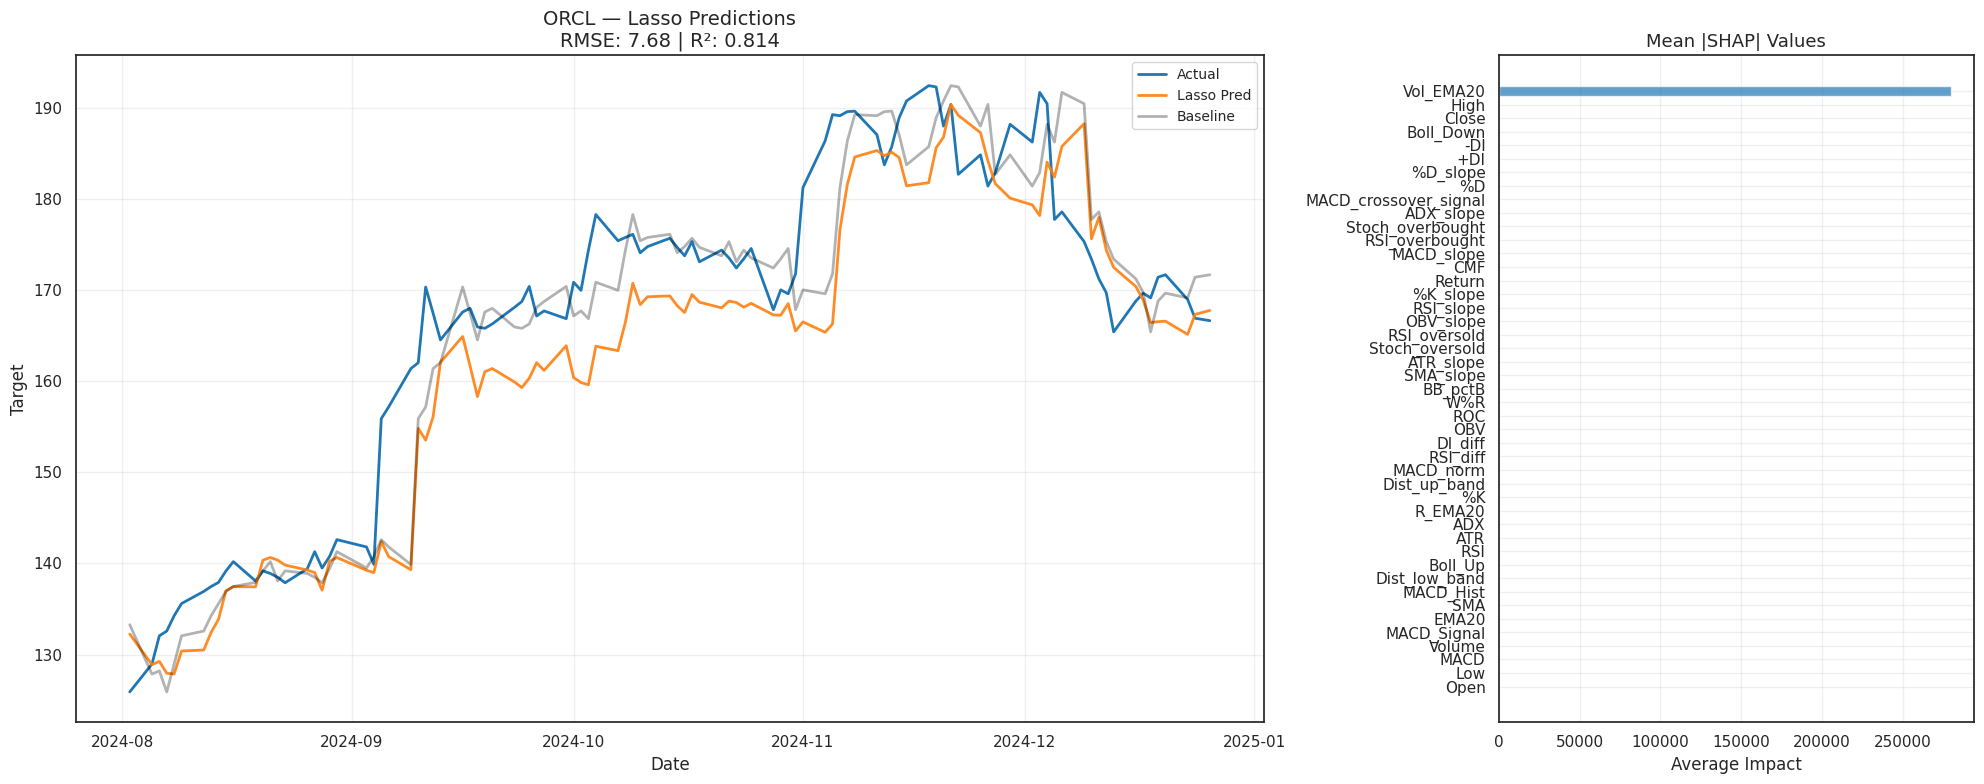

In [ ]:
#Lasso regression
for i, data in enumerate(data_set):
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.1, 0.5, 1.0, 2.0], 
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(lasso, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(lasso, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='Baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — Lasso Predictions\nRMSE: {rmse:.2f} | R²: {r2:.3f}", fontsize=14)
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

Stock: AAPL
Best params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
RMSE: 7.8556 | MAE: 5.6107 | R2: 0.8099 | base R2: 0.8051
                              coef  mean_abs_shap
Close                      8.30992        1135.04
Low                        7.83406         1056.7
High                        7.6796        1058.86
Boll_Up                    7.57005        1090.44
EMA50                      7.49959        1023.46
SMA                        7.24932        983.844
Boll_Down                  7.20451        917.743
Open                       7.02472        956.478
EMA50_slope               0.805935       0.312789
SMA_slope                  0.55684       0.368907
MACD                      0.451616        1.39494
MACD_slope                0.434262       0.178904
ATR_lag1                  0.431761        1.39324
MACD_Hist                  0.42236       0.419044
OBV_lag1                  0.301404    1.20356e+09
Vol_EMA50                -0.260121    1.67091e+07
%K         

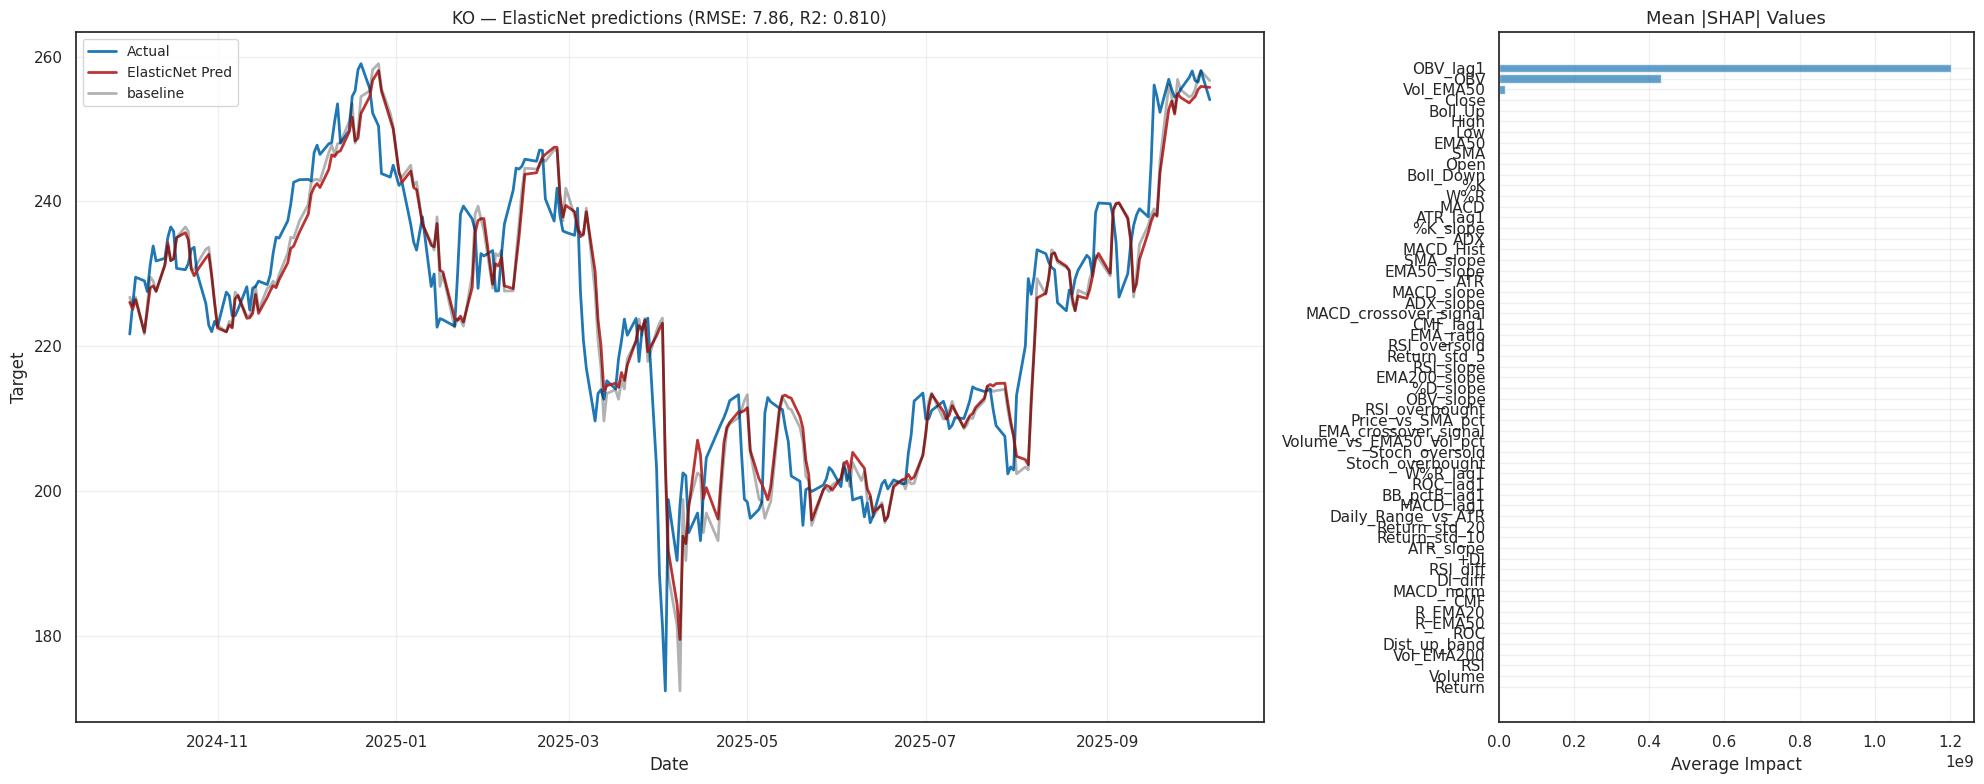

Stock: NVDA
Best params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
RMSE: 7.2717 | MAE: 5.8198 | R2: 0.9073 | base R2: 0.9178
                              coef  mean_abs_shap
Close                       3.6686        460.506
Low                        3.59549        443.501
Boll_Up                    3.49328        467.211
Open                       3.36749        422.541
EMA50                        3.215        386.944
High                       3.21217        409.006
SMA                        2.90948        358.315
Boll_Down                  2.23088        251.115
EMA200_slope              0.616606       0.137985
EMA50_slope               0.514523       0.229877
ATR_lag1                  0.450236        2.05365
MACD_slope                0.374612       0.133055
SMA_slope                 0.321684       0.204526
MACD_Hist                 0.212398       0.176574
OBV_lag1                  0.130093    6.80864e+09
OBV                       0.123222    6.44101e+09
+DI        

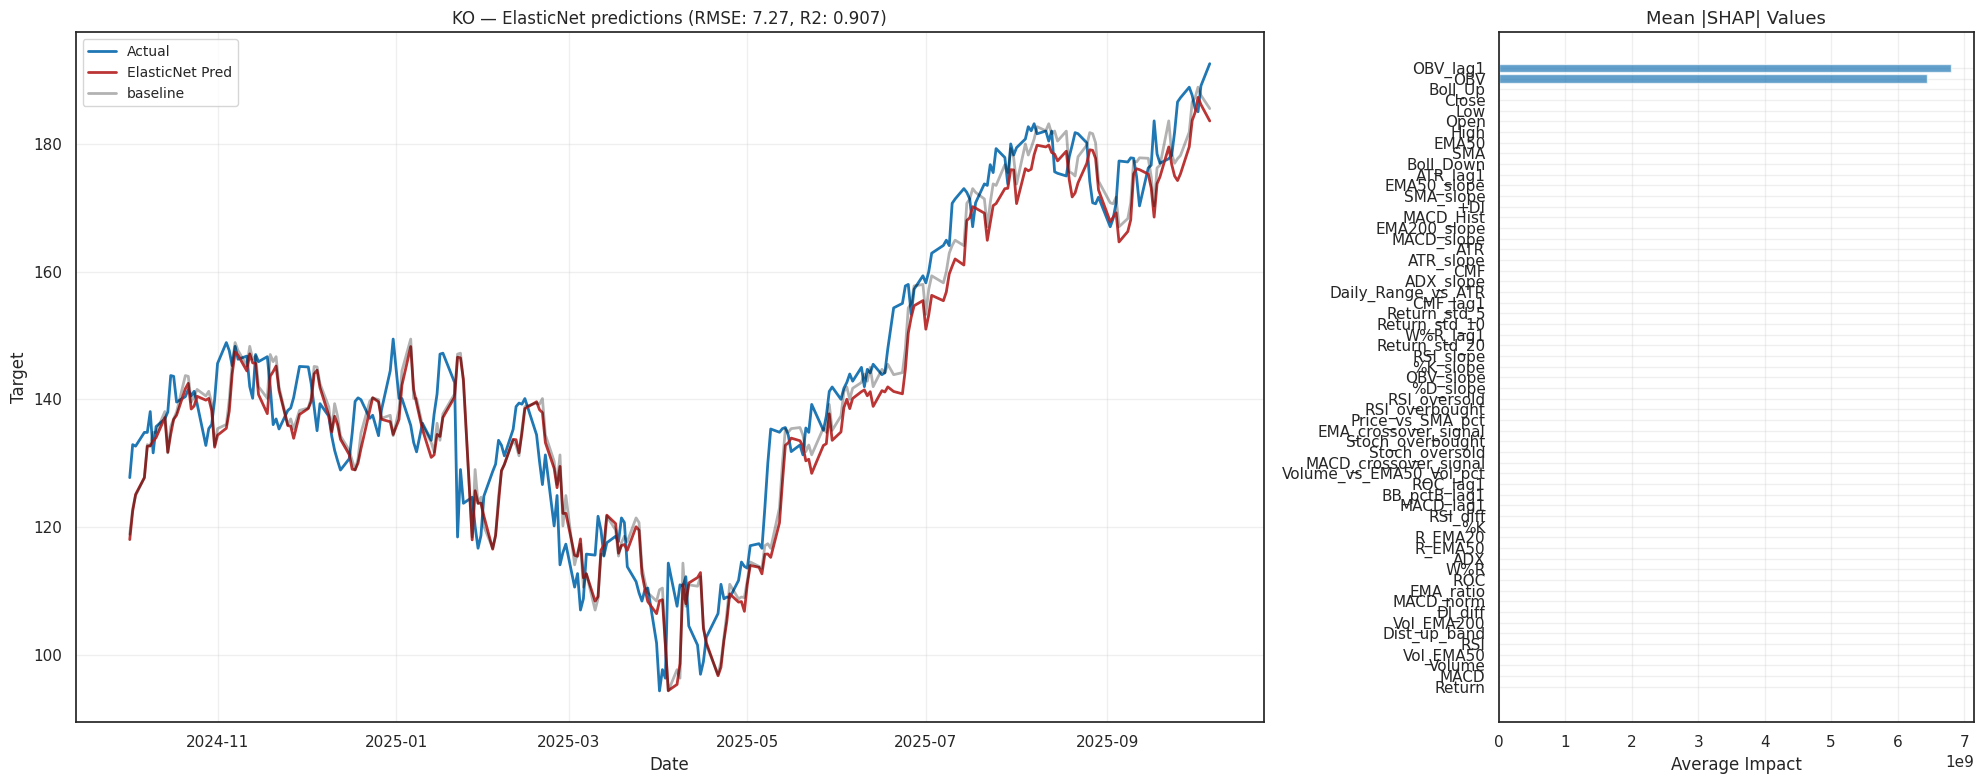

Stock: KO
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 1.2785 | MAE: 0.9679 | R2: 0.8624 | base R2: 0.8679
                                coef  mean_abs_shap
Low                          1.72869        29.2916
Close                        1.71306        29.3683
Open                         1.40306        23.9641
High                         1.36037        23.4297
SMA                         0.489699        8.53629
Boll_Down                   0.330836        5.57781
OBV_lag1                    0.303226    3.18016e+08
EMA50                       0.248343         4.4007
MACD_Hist                   0.161704      0.0289858
RSI                         0.138281        1.44848
Dist_up_band              -0.0960967     0.00176486
Return                     0.0954459    0.000787053
EMA200_slope               0.0802484     0.00213969
Return_std_5              -0.0764247    0.000237328
EMA50_slope                0.0670377     0.00536666
MACD_norm                 -0.0

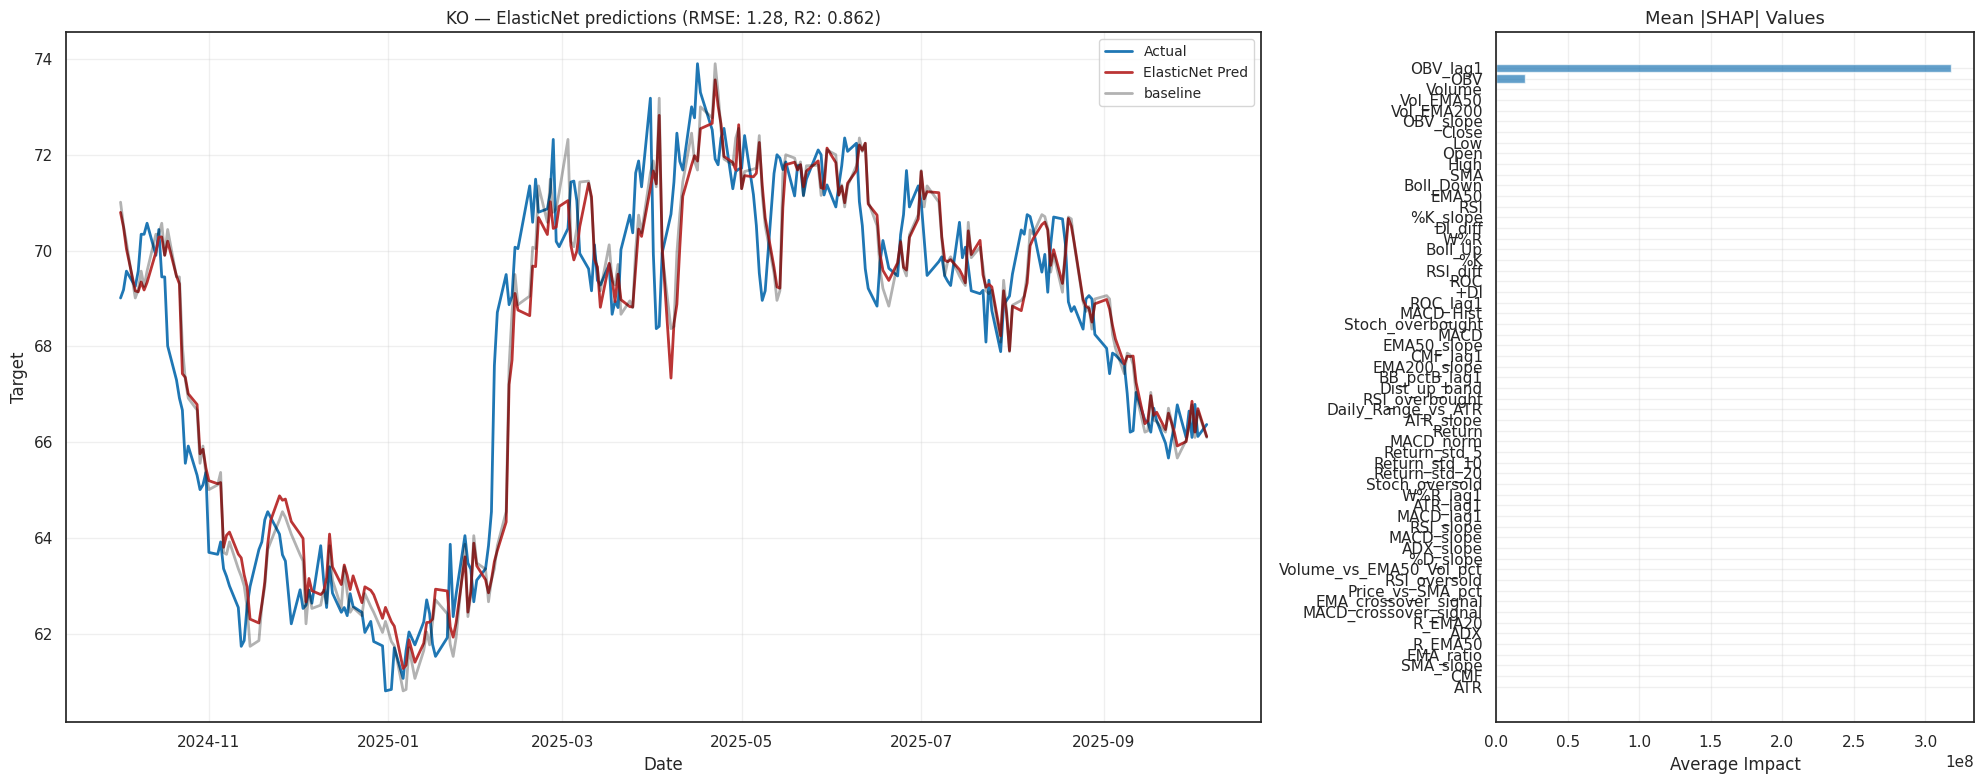

In [ ]:
# Elatic-net
for i, data in enumerate(data_set):
    pipe = make_pipeline(StandardScaler(), ElasticNet(random_state=42, max_iter=20000))

    param_grid = {
        'elasticnet__alpha': [0.01, 0.1, 0.5, 1.0],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    try:
        enet = best.named_steps['elasticnet']
        coefs = pd.Series(enet.coef_, index=data["X_train"].columns)
    except Exception:
        pass

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(enet, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(enet, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='ElasticNet Pred', color='#b41f1f', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — ElasticNet predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT (manual bar chart) ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

Stock: AAPL
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 300, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 16.6615 | MAE: 13.3280 | R2: 0.1449 | base R2: 0.8051
Top features (ordered by importance) with corresponding mean |SHAP|:
                               coef  mean_abs_shap
Close                      0.316347        52.4578
SMA                         0.26193        19.7159
Low                        0.180038        17.2494
EMA50                      0.136753        5.20286
Boll_Down                 0.0437936        5.01607
Open                      0.0312659        7.85253
High                      0.0204668        6.46121
Vol_EMA200                0.0017319        2.52169
Boll_Up                  0.00168574        1.89607
OBV_lag1                 0.00111919        1.06409
MACD_lag1               0.000227448       0.262164
OBV                     0.000215019       0.331697
Vol_EMA50               0.

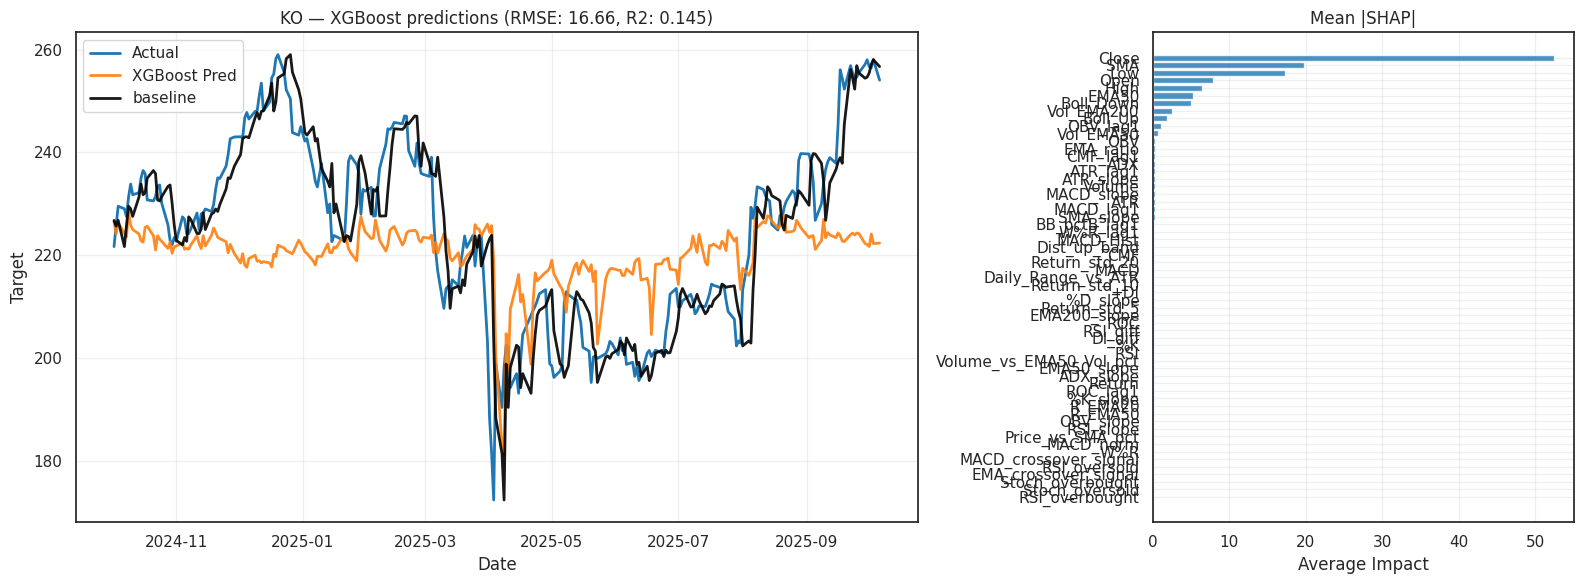

Stock: NVDA
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 300, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 37.8269 | MAE: 30.9550 | R2: -1.5085 | base R2: 0.9178
Top features (ordered by importance) with corresponding mean |SHAP|:
                               coef  mean_abs_shap
Close                      0.314407        36.9166
Open                       0.151041        8.05836
SMA                        0.127364        12.3143
Boll_Up                   0.0827813        1.47799
OBV                       0.0701629        5.64004
Low                       0.0642797        5.44733
High                       0.059047        4.47082
EMA50                     0.0551923        8.02518
OBV_lag1                  0.0273329        3.11006
Boll_Down                 0.0183015        3.73698
ATR                       0.0111838        3.30739
Return_std_20            0.00491347       0.732722
ATR_lag1                

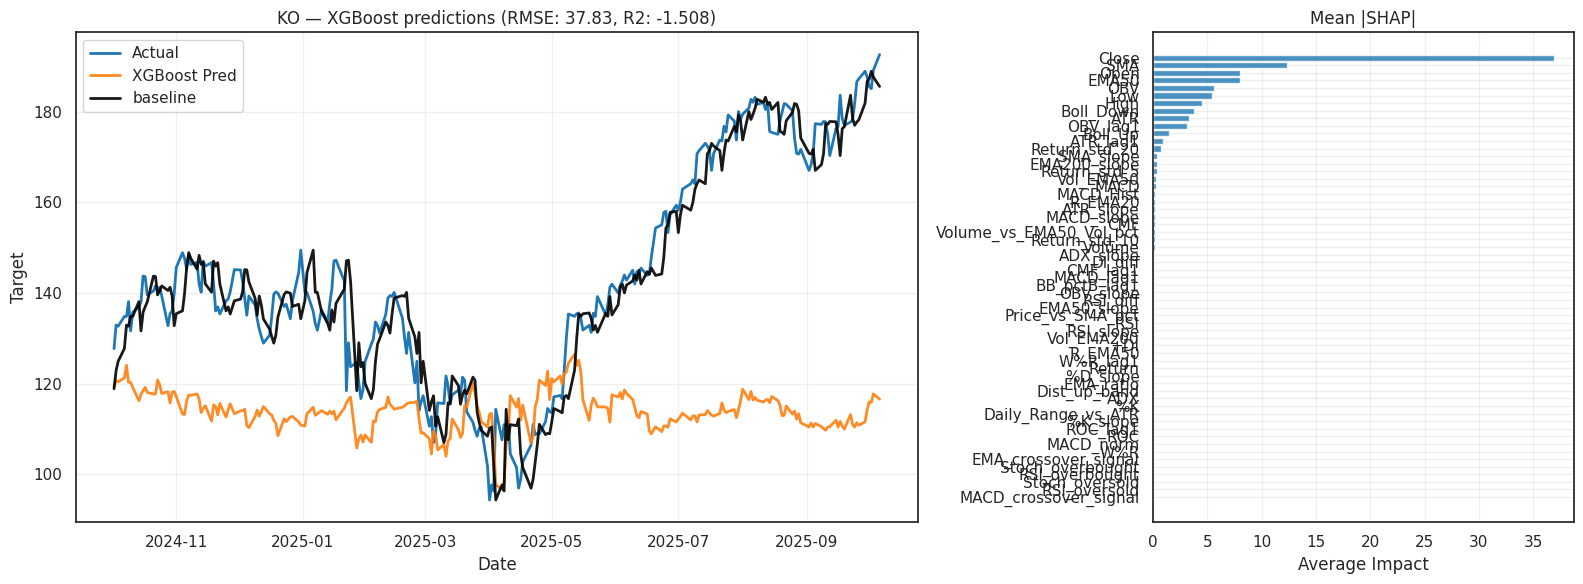

Stock: KO
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 800, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 1.6229 | MAE: 1.2818 | R2: 0.7783 | base R2: 0.8679
Top features (ordered by importance) with corresponding mean |SHAP|:
                               coef  mean_abs_shap
Low                        0.438095        5.73165
Close                      0.236286        4.94029
Open                       0.129805        1.44417
High                        0.12578        1.62925
Boll_Down                0.00864658       0.436964
OBV                      0.00631981       0.520521
SMA                      0.00610459       0.356254
Boll_Up                  0.00599746       0.573549
OBV_lag1                 0.00474584       0.319661
EMA50                    0.00211224      0.0483239
MACD_crossover_signal    0.00182437    0.000899129
EMA200_slope             0.00145419      0.0680633
MACD_Hist                0.00

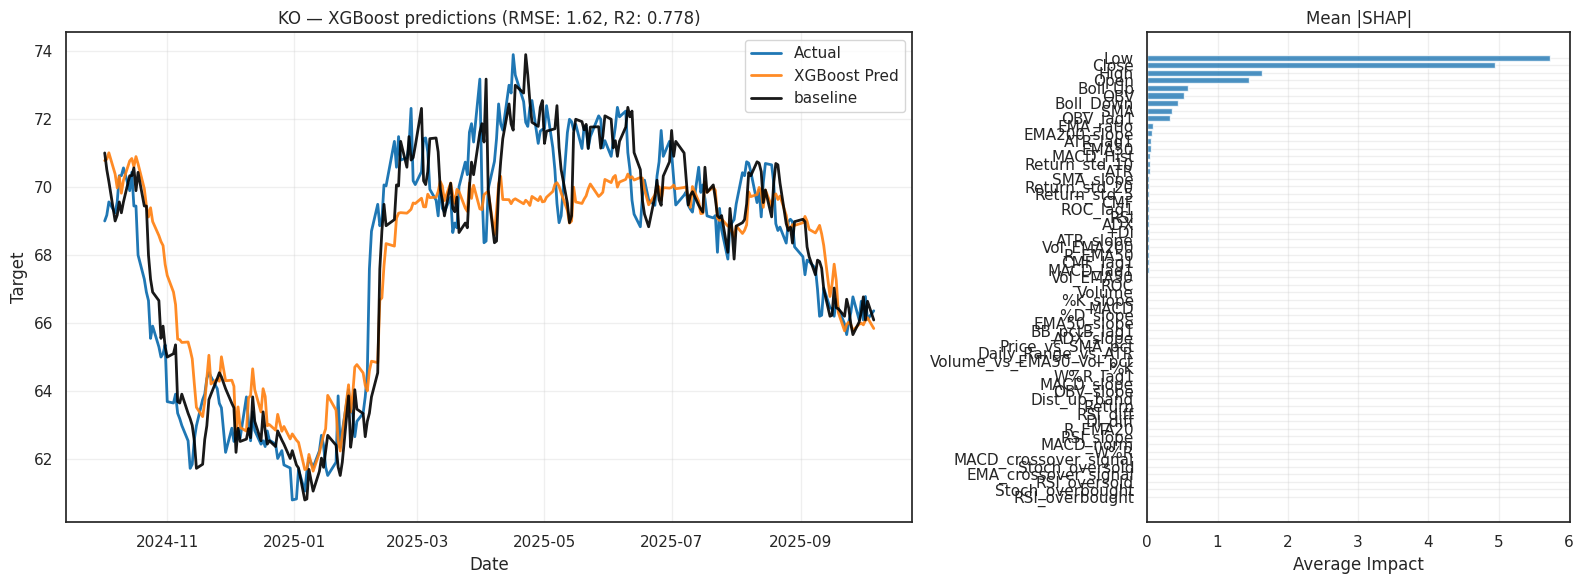

In [ ]:
for i,data in enumerate(data_set):
    pipe = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0))])

    param_grid = {
        'xgb__n_estimators': [300, 800, 1000],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.4, 0.8],
        'xgb__colsample_bytree': [0.8],
        'xgb__reg_lambda': [2],
        'xgb__min_child_weight': [5]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # feature importances as 'coef' equivalent
    model = best.named_steps['xgb']
    try:
        coefs = pd.Series(model.feature_importances_, index=data["X_train"].columns)
    except Exception:
        coefs = pd.Series(0, index=data["X_train"].columns)

    # compute SHAP values (TreeExplainer preferred)
    shap_values = None
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(model, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (importance + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — features ordered by importance:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        # shap_values may be list (multi-output) or array
        if isinstance(shap_values, list):
            if len(shap_values) == 1:
                sv = shap_values[0]
            else:
                sv = np.array(shap_values).mean(axis=0)
        elif hasattr(shap_values, "values"):
            sv = shap_values.values  # type: ignore
        else:
            sv = shap_values

        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print("Top features (ordered by importance) with corresponding mean |SHAP|:")
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # single figure: left = actual vs predicted, right = SHAP summary (bar)
    fig, (ax_main, ax_shap) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

    # main time-series plot on left
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='XGBoost Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    ax_main.set_title(f"{stock} — XGBoost predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date")
    ax_main.set_ylabel("Target")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # SHAP bar summary on right
    try:
        plot_series = combined["mean_abs_shap"].sort_values(ascending=True)
        ax_shap.barh(plot_series.index, plot_series.values, color="#1f77b4", alpha=0.8)
        ax_shap.set_title("Mean |SHAP|")
        ax_shap.set_xlabel("Average Impact")
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center')
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()